In [ ]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from scipy.stats import reciprocal, uniform

np.random.seed(42)

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (9, 6)

# Etude 1 - Training a Decision Tree

Train and fine-tune a Decision Tree for the moons dataset.

Generate a moons dataset using make_moons(n_samples=10000, noise=0.4).

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [ ]:
X.shape

(10000, 2)

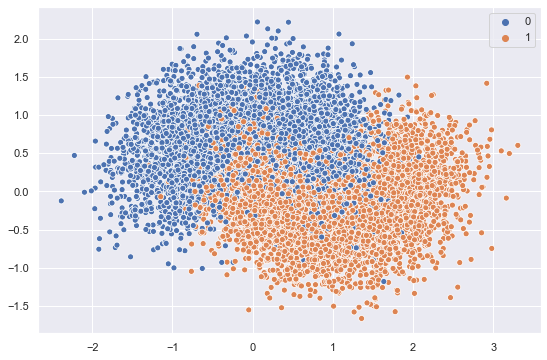

In [ ]:
sns.scatterplot(X[:, 0], X[:, 1], hue=y);

Split it into a training set and a test set using train_test_split().

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Use grid search with cross-validation (with the help of the GridSearchCV class) to find good hyperparameter values for a DecisionTreeClassifier.
Hint: try various values for max_leaf_nodes.

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

In [ ]:

gs_params = {
    'max_leaf_nodes': list(range(2, 150)),
    'min_samples_split':  list(range(2, 10))
}

gs = GridSearchCV(dt, gs_params, cv=3, n_jobs=-1)

Train it on the full training set using these hyperparameters, and measure your model’s performance on the test set. You should get roughly 85% to 87% accuracy.

In [ ]:
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8695

In [ ]:
gs.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

# Etude 2 - Implementing a Simple Random Forest Classifier

Grow a forest.

Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn’s ShuffleSplit class for this.

In [ ]:
shuffle = ShuffleSplit(n_splits=1000, train_size=100, random_state=42)

In [ ]:
subsets = []

In [ ]:
for train_index, test_index in shuffle.split(X_train):
    X_train_batch = X_train[train_index]
    y_train_batch = y_train[train_index]
    subsets.append([X_train_batch, y_train_batch])

Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [ ]:
from sklearn.base import clone

n_trees = 1000

accuracy_scores = []
estimators = [clone(gs.best_estimator_) for _ in range(n_trees)]

for estimator, (X_train_batch, y_train_batch) in zip(estimators, subsets):
    estimator.fit(X_train_batch, y_train_batch)
    y_small_predict = estimator.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_small_predict))

In [ ]:
# mean accurary for 1000 decision trees
np.mean(accuracy_scores) 

0.8054499999999999

Let's verify that each estimator in the estimators list gives slightly different predictions (that is interesting how the fitted estimators appeared in the estimatoprs list, since I did not saved them; maybe we were working with the reference to the estimators?). 

In [ ]:
y_0 = estimators[0].predict(X_test)
accuracy_score(y_test, y_0)

0.7985

In [ ]:
y_1 = estimators[1].predict(X_test)
accuracy_score(y_test, y_1)

0.836

Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy’s mode() function for this). This gives you majority-vote predictions over the test set.

In [ ]:
y_pred_inter = np.empty([len(X_test), n_trees], dtype=np.uint8)

for index, estimator in enumerate(estimators):
    y_pred_inter[:, index] = estimator.predict(X_test)

In [ ]:
y_pred_inter.shape

(2000, 1000)

In [ ]:
from scipy.stats import mode

votes, count = mode(y_pred_inter, axis=1)

Note that mode() returned an array.

In [ ]:
votes.shape

(2000, 1)

Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!

In [ ]:
accuracy_score(y_test, votes)

0.872